In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import sklearn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SequentialFeatureSelector as sfs
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

import warnings
warnings.filterwarnings('ignore')

# EDA

I got some information about the features here: https://eerscmap.usgs.gov/uswtdb/api-doc/. Here is a summary:

- `t_state` [string]: State where turbine is located
- `t_county` [string]: County where turbine is located
- `p_year` [int]: Year that the turbine became operational and began providing power. Note this may differ from the year that construction began
- `retrofit` [int]: Indicator of whether the turbine has been partially retrofit after initial construction (e.g., rotor and/or nacelle replacement). 0 indicates no known retrofit. 1 indicates yes known retrofit.
- `retrofit_year` [int]: Year in which the turbine was partially retrofit.
- `t_hh` [float]: Turbine hub height in meters (m)
- `t_rd` [float]: Turbine rotor diameter in meters (m).
- `t_rsa` [float]: Turbine rotor swept area in square meters (m2)
- `t_ttlh` [float]: Turbine total height from ground to tip of a blade at its apex in meters (m)
- `xlong` [float]: Longitude of the turbine point, in decimal degrees
- `ylat` [float]: Latitude of the turbine point, in decimal degrees

### Load the dataset

In [134]:
X_train = pd.read_pickle(r'X_train.pkl')
y_train = pd.read_pickle(r'y_train.pkl')

In [135]:
X_train

,t_state,t_county,p_year,retrofit,retrofit_year,t_hh,t_rd,t_rsa,t_ttlh,xlong,ylat
46171,KS,Lincoln County,2011,0,NaN,80.0,82.5,5345.62,121.3,-98.325649,38.899765
29102,TX,Upton County,2001,1,2018.0,60.0,65.0,3318.31,92.4,-102.253399,31.238765
3757,WA,Klickitat County,2007,0,NaN,80.0,77.0,4656.63,118.6,-120.313433,45.845891
43987,CO,Logan County,2007,0,NaN,80.0,77.0,4656.63,118.6,-103.267392,40.907088
39073,NM,Quay County,2002,1,2018.0,80.0,87.0,5944.68,123.4,-104.087774,34.730923
...,...,...,...,...,...,...,...,...,...,...,...
62570,AZ,Mohave County,2021,0,NaN,89.0,127.0,12667.69,152.4,-114.437594,35.775505
38158,CO,Weld County,2021,0,NaN,89.0,127.0,12667.69,152.4,-104.033837,41.004457
860,CA,Kern County,2012,0,NaN,85.0,103.0,8332.29,136.6,-118.241090,35.095572
15795,OK,Pontotoc County,2020,0,NaN,89.0,127.0,12667.69,152.4,-96.800879,34.517420


In [62]:
y_train

,t_cap
46171,1500
29102,1300
3757,1500
43987,1500
39073,1500
...,...
62570,2820
38158,2820
860,2850
15795,2820


### Visualize

Text(0.5, 1.0, 'Turbine Capacity vs. Hub Height')

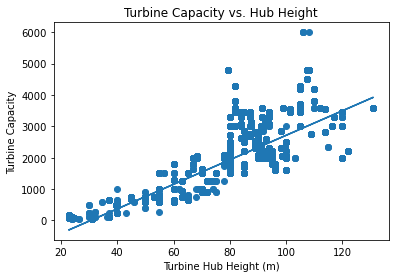

In [6]:
plt.scatter(X_train['t_hh'], y_train['t_cap'])
m, b = np.polyfit(X_train['t_hh'], y_train['t_cap'], 1)
plt.plot(X_train['t_hh'], m*X_train['t_hh'] + b)

plt.xlabel("Turbine Hub Height (m)")
plt.ylabel("Turbine Capacity")
plt.title("Turbine Capacity vs. Hub Height")

Text(0.5, 1.0, 'Turbine Capacity vs. Rotor Diameter')

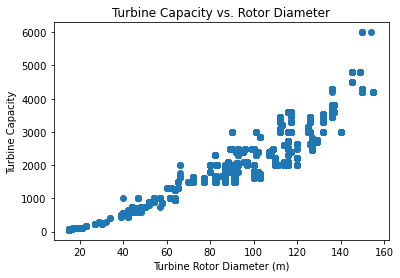

In [7]:
plt.scatter(X_train['t_rd'], y_train['t_cap'])

plt.xlabel("Turbine Rotor Diameter (m)")
plt.ylabel("Turbine Capacity")
plt.title("Turbine Capacity vs. Rotor Diameter")

Text(0.5, 1.0, 'Turbine Capacity vs. Rotor Swept Area')

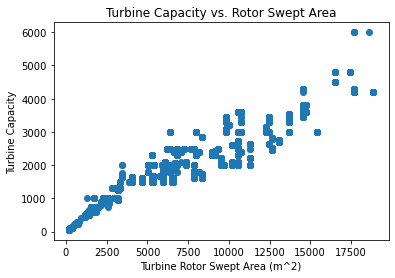

In [8]:
plt.scatter(X_train['t_rsa'], y_train['t_cap'])
plt.xlabel("Turbine Rotor Swept Area (m^2)")
plt.ylabel("Turbine Capacity")
plt.title("Turbine Capacity vs. Rotor Swept Area")

Text(0.5, 1.0, 'Turbine Capacity vs. Year operational')

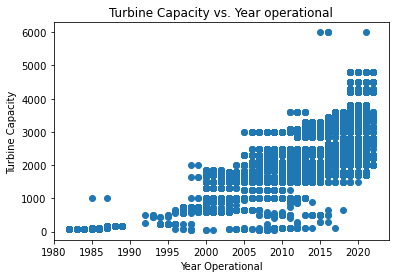

In [9]:
plt.scatter(X_train['p_year'], y_train['t_cap'])
plt.xlabel("Year Operational")
plt.ylabel("Turbine Capacity")
plt.title("Turbine Capacity vs. Year operational")

Text(0.5, 1.0, 'Distribution of Year Turbines Became Operational')

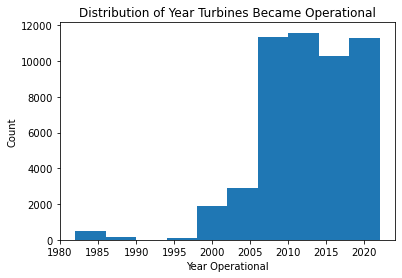

In [10]:
plt.hist(X_train['p_year'])
plt.xlabel("Year Operational")
plt.ylabel("Count")
plt.title("Distribution of Year Turbines Became Operational")

# Create KNN and Training

We split this training process into several steps:

1. Preprocessing: We will choose a set of features using forward selection.
2. Test several values of $k$ (where $k$ is the number of nearest neighbors) using CV
    - Figure out how many folds in k-fold CV
    - Be sure to take into account bias and variance
3. Use this optimal $k$ to train KNN model
    - Loss function: MSE $= (y-f(x))^2$
    - Figure out number of epochs
    - Consider initialization

### 1. Preprocessing

We clean our dataset and then use forward selection to choose an optimal subset of features. Namely, we will encode the labels for states and counties. We remove `retrofit_year` because most of its observations $\frac{45364}{50000}\approx 91\%$ are NA.

#### Cleaning data 

In [138]:
# Most observations missing in retrofit_year --> remove
X_train['retrofit_year'].isna().sum()/len(X_train['retrofit_year'])
X_train = X_train.drop(['retrofit_year'], axis = 1)

In [139]:
X_train

,t_state,t_county,p_year,retrofit,t_hh,t_rd,t_rsa,t_ttlh,xlong,ylat
46171,KS,Lincoln County,2011,0,80.0,82.5,5345.62,121.3,-98.325649,38.899765
29102,TX,Upton County,2001,1,60.0,65.0,3318.31,92.4,-102.253399,31.238765
3757,WA,Klickitat County,2007,0,80.0,77.0,4656.63,118.6,-120.313433,45.845891
43987,CO,Logan County,2007,0,80.0,77.0,4656.63,118.6,-103.267392,40.907088
39073,NM,Quay County,2002,1,80.0,87.0,5944.68,123.4,-104.087774,34.730923
...,...,...,...,...,...,...,...,...,...,...
62570,AZ,Mohave County,2021,0,89.0,127.0,12667.69,152.4,-114.437594,35.775505
38158,CO,Weld County,2021,0,89.0,127.0,12667.69,152.4,-104.033837,41.004457
860,CA,Kern County,2012,0,85.0,103.0,8332.29,136.6,-118.241090,35.095572
15795,OK,Pontotoc County,2020,0,89.0,127.0,12667.69,152.4,-96.800879,34.517420


In [140]:
# Label encoding for string columns
le = preprocessing.LabelEncoder()

X_train['t_state'] = le.fit_transform(X_train['t_state'])
X_train['t_county'] = le.fit_transform(X_train['t_county'])

In [141]:
X_train

,t_state,t_county,p_year,retrofit,t_hh,t_rd,t_rsa,t_ttlh,xlong,ylat
46171,10,249,2011,0,80.0,82.5,5345.62,121.3,-98.325649,38.899765
29102,34,409,2001,1,60.0,65.0,3318.31,92.4,-102.253399,31.238765
3757,38,234,2007,0,80.0,77.0,4656.63,118.6,-120.313433,45.845891
43987,3,252,2007,0,80.0,77.0,4656.63,118.6,-103.267392,40.907088
39073,23,341,2002,1,80.0,87.0,5944.68,123.4,-104.087774,34.730923
...,...,...,...,...,...,...,...,...,...,...
62570,1,286,2021,0,89.0,127.0,12667.69,152.4,-114.437594,35.775505
38158,3,425,2021,0,89.0,127.0,12667.69,152.4,-104.033837,41.004457
860,2,224,2012,0,85.0,103.0,8332.29,136.6,-118.241090,35.095572
15795,27,331,2020,0,89.0,127.0,12667.69,152.4,-96.800879,34.517420


In [142]:
# Count NA rows in each dataset
print('X_train null values:\n', X_train.isnull().sum(), "\n")
print('y_train null values:\n', y_train.isnull().sum())
# X_test.isnull().sum()
# y_test.isnull().sum()

# Find row where NAs occur and remove NA rows from both X_train and y_train
na_row = X_train.isnull().any(axis = 1)
na_rows = X_train[na_row]
print(na_rows)
X_train = X_train.drop(10682)
y_train = y_train.drop(10682)

# Transform X and y into correct format
# X_train = X_train.iloc[:, 0:10].values
# y_train = y_train.iloc[:, 0].values
# X_test = X_test.iloc[:, 0:10].values
# y_test = y_test.iloc[:, 0].values

X_train null values:
 t_state     0
t_county    0
p_year      0
retrofit    0
t_hh        0
t_rd        1
t_rsa       1
t_ttlh      1
xlong       0
ylat        0
dtype: int64 

y_train null values:
 t_cap    0
dtype: int64
       t_state  t_county  p_year  retrofit  t_hh  t_rd  t_rsa  t_ttlh  \
10682       26       109    2009         0  37.0   NaN    NaN     NaN   

           xlong       ylat  
10682 -81.614799  41.508792  


#### Scale the data

In [70]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# y_train = scaler.fit_transform(y_train)
# X_test = scaler.transform(X_test)

#### Model selection

In [173]:
# # Defining list of k values to search for KNN
# k_range = range(1, 26) # Values 1-25
# k_loss = [] # Array to store validation losses

# from sklearn.model_selection import cross_val_score
# k_scores = []

# for k in k_range:
    
#     print('k-value ', k)
    
#     # Run KNN with k neighbors
#     knn = KNeighborsRegressor(n_neighbors = k)
#     knn.fit(X_train, y_train)
#     y_pred = knn.predict(X_train)
    
#     scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
#     k_scores.append(scores.mean())
    
#     # Calculate KNN MSE loss with k neighbors
#     loss = mean_squared_error(y_train, y_pred)
#     k_loss.append(loss)


k-value  1
k-value  2
k-value  3
k-value  4
k-value  5
k-value  6
k-value  7
k-value  8
k-value  9
k-value  10
k-value  11
k-value  12
k-value  13
k-value  14
k-value  15
k-value  16
k-value  17
k-value  18
k-value  19
k-value  20
k-value  21
k-value  22
k-value  23
k-value  24
k-value  25


Text(0.5, 1.0, 'KNN MSE Loss for Different Values of K')

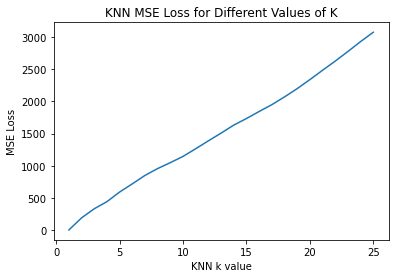

In [147]:
# # Plot results
# plt.plot(k_range, k_loss)
# plt.xlabel('KNN k value')
# plt.ylabel('MSE Loss')
# plt.title('KNN MSE Loss for Different Values of K')

In [214]:
# https://stats.stackexchange.com/questions/110599/how-to-get-both-mse-and-r2-from-a-sklearn-gridsearchcv
def MSE(y_true,y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return mse

def MSE_score():
    return make_scorer(MSE, greater_is_better = False)

folds = 10
knn = KNeighborsRegressor()
kfoldcv = KFold(n_splits = folds, shuffle = True, random_state = 535)

hyp = [{'n_neighbors': [1,3,5,7,9,11,13,15]}]
grid = GridSearchCV(estimator = knn, param_grid = hyp, cv = kfoldcv, scoring = MSE_score())
grid.fit(X_train, y_train)

print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

-792.218432970594
KNeighborsRegressor(n_neighbors=1)
{'n_neighbors': 1}


In [215]:
grid.cv_results_['params'] 
grid.cv_results_['mean_test_score'] 

array([ -792.21843297,  -850.88794269, -1103.87625992, -1337.31408519,
       -1562.85623253, -1828.65043905, -2072.15353255, -2349.26360241])

In [216]:
neigh = [1,3,5,7,9,11,13,15]

Text(0.5, 1.0, 'KNN MSE Loss for Different Values of K')

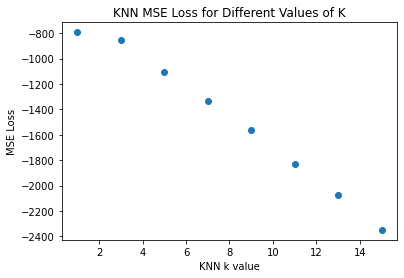

In [217]:
# Plot results
plt.scatter(neigh, grid.cv_results_['mean_test_score'] )
plt.xlabel('KNN k value')
plt.ylabel('MSE Loss')
plt.title('KNN MSE Loss for Different Values of K')

Choose $k=3$ because $k=1$ with loss of zero will likely overfit, so this gives us the next lowest MSE loss.

#### Fit a model using the optimized parameters

In [152]:
knn = KNeighborsRegressor(n_neighbors = 3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_train)

We can check the model fit on some features against `t_cap`, what we would like to predict, like we did in our EDA. 

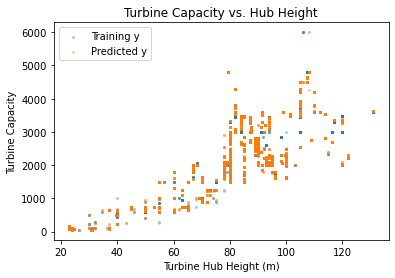

In [189]:
plt.scatter(X_train['t_hh'], y_train, s = 4, label = "Training y", alpha = 0.3)
plt.scatter(X_train['t_hh'], y_pred, s = 4, label = "Predicted y", alpha = 0.3)

plt.xlabel("Turbine Hub Height (m)")
plt.ylabel("Turbine Capacity")
plt.title("Turbine Capacity vs. Hub Height")
plt.legend(loc='upper left')

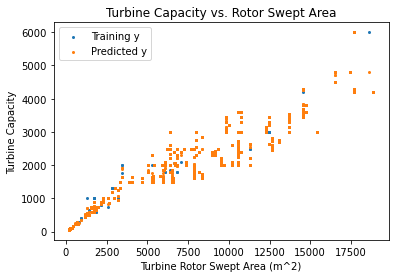

In [170]:
plt.scatter(X_train['t_rsa'], y_train, s = 4, label = "Training y")
plt.scatter(X_train['t_rsa'], y_pred, s = 4, label = "Predicted y")

plt.xlabel("Turbine Rotor Swept Area (m^2)")
plt.ylabel("Turbine Capacity")
plt.title("Turbine Capacity vs. Rotor Swept Area")
plt.legend(loc='upper left')

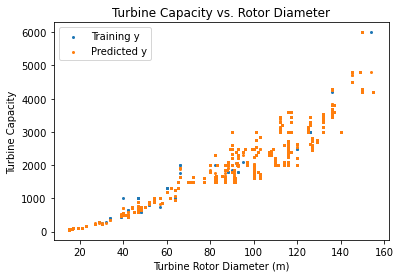

In [171]:
plt.scatter(X_train['t_rd'], y_train, s = 4, label = "Training y")
plt.scatter(X_train['t_rd'], y_pred, s = 4, label = "Predicted y")

plt.xlabel("Turbine Rotor Diameter (m)")
plt.ylabel("Turbine Capacity")
plt.title("Turbine Capacity vs. Rotor Diameter")
plt.legend(loc='upper left')

#### Learning curve